# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.sort_values(by="article_id").head(5)

,article_id,title,email
1935,0.0,detect malfunctioning iot sensors with streami...,384255292a8223e84f05ca1e1deaa450c993e148
40755,0.0,detect malfunctioning iot sensors with streami...,8bd0afc488016810c287ac4ec844895d570b0af4
42948,0.0,detect malfunctioning iot sensors with streami...,451a9a4a4cb1cc4e5f38d04e8859cc3fb275cc66
2328,0.0,detect malfunctioning iot sensors with streami...,ca7d48adf2c7394ed5a8776de959fa8047e43d4b
19242,0.0,detect malfunctioning iot sensors with streami...,a60b7e945a8f2114d5dfbdd53182ad1d526534e2


In [57]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [58]:
# To find the number of articles an user has interacted with, lets first group the  "user-item-interactions" dataset by the "email" column
groupby_email = df.groupby(by="email")

In [59]:
# check to see if groupby_email DataframeGroupBy object is instantiated 
groupby_email

In [60]:
# Lets now see the number of articles each user has interacted with
user_interaction_counts=groupby_email["article_id"].count()
user_interaction_counts

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
                                            ..
ffc6cfa435937ca0df967b44e9178439d04e3537     2
ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d     4
ffe3d0543c9046d35c2ee3724ea9d774dff98a32    32
fff9fc3ec67bd18ed57a34ed1e67410942c4cd81    10
fffb93a166547448a0ff0232558118d59395fecd    13
Name: article_id, Length: 5148, dtype: int64

In [61]:
# Fill in the median and maximum number of user_article interactions below

median_val = user_interaction_counts.median() #50% of individuals interact with 3 number of articles or fewer.
max_views_by_user = user_interaction_counts.max() # The maximum number of user-article interactions by any 1 user is 364.
median_val,max_views_by_user

(3.0, 364)

In [62]:
# lets now look at some stats around the counts of articles interaction by the users using the describe() method
user_interaction_counts.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

> looks like the the max number of articles any 1 user has interacted with is 364 and the median is 3, and on average an user has interacted with around 9 articles

In [63]:
# lets create a function to plot a simple visual that shows the frequency distribution of user interactions  with the articles

from matplotlib.pyplot import title


def plot_user_interactions_counts(df,plot_type):
    """
    A function to plot a visual around the user interaction counts with the articles
    
    Paramters
    df: name of the df that is grouped by email and has counts of articles per email 
    plot_type: kind of chart in a string format
    
    Returns
    Plot with frequency of user interaction  with the articles
    """

    return df.plot(kind=plot_type, title="user-article interactions")

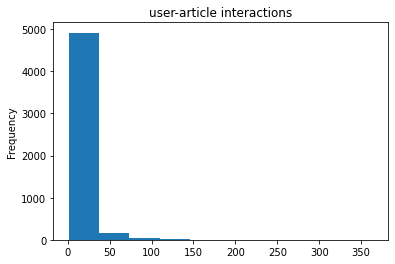

In [64]:
# Calling the plot_user_interactions_counts function to plot the user interaction counts using a histogram
plot_user_interactions_counts(user_interaction_counts,"hist");

> the above histogram shows the distribution of interactions

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [65]:
# Find and explore duplicate articles
# lets first look at a sample of the dataframe
df_content.sample(5)

,doc_body,doc_description,doc_full_name,doc_status,article_id
805,CONNECTING TO COMPOSE FOR MYSQL\r\nShare on Tw...,"Here, we'll take you from provisioning your ow...",Connecting to Compose for MySQL,Live,802
49,Compose The Compose logo Articles Sign in Free...,We'll also look at using PostGIS to filter our...,GeoFile: Using OpenStreetMap Data in Compose P...,Live,49
502,G. Adam Cox Blocked Unblock Follow Following J...,The SETI@IBMCloud project and the SETI Institu...,Defensive IBM Object Storage Containers – IBM ...,Live,501
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
386,Skip to main content IBM developerWorks / Deve...,See how to load new geospatial data into your ...,Load geospatial data into dashDB to analyze in...,Live,385


In [66]:
# lets first check for any duplicte rows as whole
df_content.duplicated().sum()

0

> there are no duplicate rows as a whole (repeated rows)

In [67]:
# lets check for duplicate article ids
df_content[df_content.duplicated(subset=["article_id"])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [68]:
# Lets take an article Id from the above results and have a look at the duplicate rows with that article Id 
df_content[df_content.loc[:,"article_id"]==221]

,doc_body,doc_description,doc_full_name,doc_status,article_id
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221


In [69]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=["article_id"], keep='first')

In [70]:
# Test if the drop duplicate method worked by pulling an article id from one of the previous results (pre-drop)
df_content[df_content.loc[:,"article_id"]==221]

,doc_body,doc_description,doc_full_name,doc_status,article_id
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221


> Looks like the drop_duplicate method worked fine

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [71]:
# to look at the number of unique articles that have an interaction with a user , lets first look at articles in the df
df["article_id"]

0        1430.0
1        1314.0
2        1429.0
3        1338.0
4        1276.0
          ...  
45988    1324.0
45989     142.0
45990     233.0
45991    1160.0
45992      16.0
Name: article_id, Length: 45993, dtype: float64

In [72]:
# lets do a unique value count using the nunique() method on the above series to find out the number of unique articles that have an interaction with a user
df["article_id"].nunique()

714

In [73]:
# to find the number of unique articles in the dataset (whether they have any interactions or not). Lets look at the articles in df_content and use the nunique() method
df_content["article_id"].nunique()

1051

In [74]:
# to find number of unique users in the dataset. (excluding null values), lets just call the nunique() method on the email column of the df dataframe
df["email"].nunique()

5148

In [75]:
# to find the number of user-article interactions in the dataset, lets just call the shape attribute on the df dataframe and use slice notation to find the number of rows
df.shape[0]

45993

In [76]:
unique_articles = df["article_id"].nunique() # The number of unique articles that have at least one interaction
total_articles = df_content["article_id"].nunique() # The number of unique articles on the IBM platform
unique_users = df["email"].nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [77]:
# to find the most viewed article_id, as well as how often it was viewed.
# lets call the value_counts() method on the article_id column of the df dataframe
# and also use the head(1) method to display the top most article_id 
df["article_id"].value_counts(ascending=False).head(1)


1429.0    937
Name: article_id, dtype: int64

In [78]:
most_viewed_article_id = '1429.0'  # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [79]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [80]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [81]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles=list(df.title.value_counts().head(n).index) # value_counts() method to create series of counts of titles and head() function to retrieve the top n records
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles=list(df.article_id.value_counts().head(n).index) # value_counts() method to create series of counts of ids and head() function to retrieve the top n records
    top_articles = [str(x) for x in top_articles]
    return top_articles # Return the top article ids

In [82]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [83]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [84]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    unstacked=df.groupby(['user_id', 'article_id']).count().unstack().fillna(0) # group by user id and article ids and perfrom count agg and unstack rows to columns while filling nulls with 0s
    unstacked.columns= unstacked.columns.droplevel() # drop the extra column level (level not needed for our matrix)
    user_item=unstacked.applymap(lambda x: 1 if x > 1 else x ) # making sure all the values inside the matrix is either 0 or 1
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [85]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [86]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity_series = user_item.dot(user_item.T)[user_id]
    # sort by similarity
    most_similar_users=similarity_series.sort_values(ascending = False)
    # create list of just the ids
    most_similar_users=list(most_similar_users.index)
    # remove the own user's id
    most_similar_users.remove(user_id)

    return most_similar_users # return a list of the users in order from most to least similar
        

In [87]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [88]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [89]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # create a list of article names identified by the the title column associated with the list of article ids 
    article_names = [df[df["article_id"] == float(x)]["title"].max() for x in article_ids]

    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # pull all the article ids for the user which donot zeros for their values in the user_item df
    article_ids = user_item.loc[user_id][user_item.loc[user_id] != 0].index.astype(str)
    # pass the article_ids to the get_article_names function to get the article names for those ids
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Ids of articles seen by user (we don't want to recommend these)
    user_seen = get_user_articles(user_id)[0] 
    # Similar users to the current user
    similar_users = find_similar_users(user_id)

    # Keep the recommended articles here
    recs = []

    # Go through the similar users and identify articles they like the user hasn't seen
    for similar_user in similar_users:
        similar_user_seen = get_user_articles(similar_user)[0]
        # Obtain recommendations from similar user without the articles seen by the user
        new_recs = np.setdiff1d(similar_user_seen, user_seen, assume_unique=True)
        # Update recs with new recs; concat rec and new_rec arrays and return only unique values
        recs = np.unique(np.concatenate([new_recs, recs], axis = 0)) 

        # If we have enough recommendations exit the loop
        if len(recs) > m-1:
            break
    
    

    return recs[:m] # return your recommendations for this user_id    

In [91]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [92]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [93]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # create an empty dataframe with "neighbor_id", "similarity","num_interactions" columns
    neighbors_df=pd.DataFrame(columns=["neighbor_id", "similarity","num_interactions"]) 
    
    # set the "neighbor_id" column and remove the own user_id of the user 
    neighbors_df["neighbor_id"]=[id for id in range(1,user_item.shape[0]) if id != user_id]   
    
    # set the "similarity" column to most similar using dot product 
    neighbors_df["similarity"] = neighbors_df["neighbor_id"].apply(lambda x: np.dot(user_item.loc[user_id], user_item.loc[x]))

    
    # set the "num_interactions" column to user_interactions_counts series
    # create a series of user_interactions_counts created using grouping of "user_id"
    user_interactions_counts = df.groupby(["user_id"])["article_id"].count()
    neighbors_df["num_interactions"]=neighbors_df["neighbor_id"].apply(lambda x: user_interactions_counts.loc[x].sum())

    # sort dataframe ascending by "similarity","num_interactions" and reset index to start from 0
    neighbors_df=neighbors_df.sort_values(by=["similarity","num_interactions"],ascending=False).reset_index(drop=True)

    return neighbors_df # Return the dataframe specified in the doc_string





def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 4
    before choosing those with fewer total interactions. 
   
    '''
    

    # article ids,names read by our user ; don't want to recommend these
    user_articles_ids_read, user_articles_names_read = get_user_articles(user_id, user_item) 
    
    # top similar user ids closest to our user
    similar_users = get_top_sorted_users(user_id, df, user_item)["neighbor_id"]
    
    # keep the recommended articles here
    recs = [] 

    for similar_user in similar_users:
        # articles read by similar user
        sim_articles_ids_read, sim_articles_names_read = get_user_articles(similar_user, user_item)
        # obtain recommendations from similar user without the articles read by our user
        new_recs = np.setdiff1d(sim_articles_ids_read, user_articles_ids_read, assume_unique=True) 
        # Update recs with new recs; concat rec and new_rec arrays and return only unique values
        recs = np.unique(np.concatenate([new_recs, recs], axis = 0)) 
        # break the loop once the number of recs have been reached
        if len(recs) > m-1:
            break

            
    recs = recs[:m]
    #recs = recs.tolist() # convert to a list
    
    rec_names = get_article_names(recs)
    
    
    return recs, rec_names

In [94]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0' '1085.0' '109.0' '1150.0' '1151.0' '1152.0' '1153.0' '1154.0'
 '1157.0' '1160.0']

The top 10 recommendations for user 20 are the following article names:
['using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: chicago listings', 'tensorflow quick tips', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice reviews', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: washington d.c. listings', 'analyze accident reports on amazon emr spark']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [95]:
get_top_sorted_users(1)

,neighbor_id,similarity,num_interactions
0,3933,35.0,45
1,23,17.0,364
2,3782,17.0,363
3,203,15.0,160
4,4459,15.0,158
...,...,...,...
5142,5131,0.0,1
5143,5141,0.0,1
5144,5144,0.0,1
5145,5147,0.0,1


In [96]:
get_top_sorted_users(1).iloc[0]

neighbor_id         3933.0
similarity            35.0
num_interactions      45.0
Name: 0, dtype: float64

In [97]:
get_top_sorted_users(131).iloc[9]

neighbor_id         242.0
similarity           25.0
num_interactions    148.0
Name: 9, dtype: float64

In [98]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0].neighbor_id # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9].neighbor_id # Find the 10th most similar user to user 131

In [99]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

If we were given a new user, I would use the get_top_articles() function and provide the user with the rank based recommendations (suggest the top ranked articles) and that is because we do not have any user-article interaction information about the user. We cannot find similar users (neighbours) if we do not have that information. The other methods individually (content, collabrative, knowledge) may not be as useful in such a situation.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [100]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here

In [101]:
new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [102]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [103]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [104]:
# a quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [105]:
# Perform SVD on the User-Item Matrix Here
u, s, vt =  np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

In [106]:
# checking to see if any rows in the user_item_matrix has an NaNs
user_item_matrix.isna().sum().sort_values(ascending=False)

article_id
0.0       0
485.0     0
443.0     0
444.0     0
446.0     0
         ..
1338.0    0
134.0     0
1340.0    0
1343.0    0
997.0     0
Length: 714, dtype: int64

> there are no rows in the matrix that has null values

In [107]:
# checking to see if any rows in the user_item_matrix have values other than 0 and 1
(~user_item_matrix.isin([0,1])).sum().sort_values(ascending=False)

article_id
0.0       0
485.0     0
443.0     0
444.0     0
446.0     0
         ..
1338.0    0
134.0     0
1340.0    0
1343.0    0
997.0     0
Length: 714, dtype: int64

> fortunately there are no rows in the matrix that have values other than 0's and 1's

**Provide your response here.**

> As there are no null values in the user_item_matrix , SVD is a very good candidate. Also the matrix has only 1's and 0's (interactions vs no interactions). As far as the lesson is concerned the matrix had lot of null values and FunkSVD was opted. But in our scenario SVD should work just fine. 

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

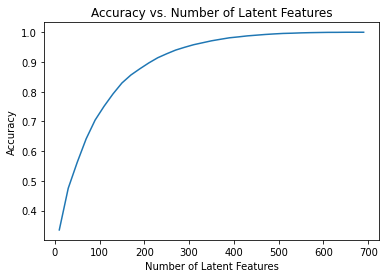

In [108]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [109]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    
    user_item_train = create_user_item_matrix(df_train) # Returns a train matrix with user ids as rows and article ids on the columns
    user_item_test = create_user_item_matrix(df_test) # Returns a test matrix with user ids as rows and article ids on the columns
    
    test_idx = user_item_test.index # all of the test user ids 
    test_arts = user_item_test.columns # all of the test article ids
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [110]:
# How many users can we make predictions for in the test set?
test_set_users = len(test_idx) 
print("No of users in test set: ",test_set_users) # no. of users in test set
train_idx = user_item_train.index # users in training set
print("No of users in train set: ",len(train_idx))
train_test_user_intersect = len((test_idx).intersection(train_idx)) # Return the number of users exist in both test and train 
print("No of users we can make predictions for in  train set: ",train_test_user_intersect)

# How many users in the test set are we not able to make predictions for because of the cold start problem?
print("No of users in the test set are we not able to make predictions for because of the cold start problem: ", np.abs((train_test_user_intersect)-len(test_idx)))

# How many movies can we make predictions for in the test set?
print("No of articles can we make predictions for in the test set: ",len(test_arts))

# How many articles are we not able to make predictions for because of the cold start problem?
print("No of articles in the test set: ",len(test_arts))
train_arts=user_item_train.columns
print("No of articles in the train set: ",len(train_arts))

train_test_articles_diff = len((test_arts).difference(train_arts)) # Return the number of articles exist in test but not train
print("Movies in the test set we're not able to make predictions for because of the cold start problem: ",train_test_articles_diff) 

No of users in test set:  682
No of users in train set:  4487
No of users we can make predictions for in  train set:  20
No of users in the test set are we not able to make predictions for because of the cold start problem:  662
No of articles can we make predictions for in the test set:  574
No of articles in the test set:  574
No of articles in the train set:  714
Movies in the test set we're not able to make predictions for because of the cold start problem:  0


In [111]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b, # replacing "articles" with "movies" to match code in project_tests.py https://knowledge.udacity.com/questions/770708
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d # replacing "articles" with "movies" to match code in project_tests.py https://knowledge.udacity.com/questions/770708
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [112]:
# lets look at a sample of 3 records from user_item_train
user_item_train.sample(3)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [114]:
# print the shapes of u,s,vt_train
print(f"u_train_shape: {u_train.shape}, s_train_shape: {s_train.shape}, vt_train_shape: {vt_train.shape} ")

u_train_shape: (4487, 4487), s_train_shape: (714,), vt_train_shape: (714, 714) 


In [115]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

# latent features
num_latent_feats = np.arange(10,700+10,20)
# keep sum of errors in train here 
sum_errors_train = []
# keep sum of errors in test here 
sum_errors_test = []

# common users 
row_index = user_item_train.index.isin(test_idx)
# common articles
col_index = user_item_train.columns.isin(test_arts)

u_test = u_train[row_index, :]
vt_test = vt_train[:, col_index]

# users we can predict for in test
test_users_predict = np.intersect1d(user_item_train.index.tolist(),user_item_test.index.to_list())
# test matrix with the users from above
user_intersect_train_test = user_item_test.loc[test_users_predict]

In [116]:
for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_pred = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_pred = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_pred)
    diffs_test = np.subtract(user_intersect_train_test, user_item_test_pred)
    
    # calculate total errors 
    train_errors = np.sum(np.sum(np.abs(diffs_train)))
    test_errors = np.sum(np.sum(np.abs(diffs_test)))

    # keep track of total errors 
    sum_errors_train.append(train_errors)
    sum_errors_test.append(test_errors)

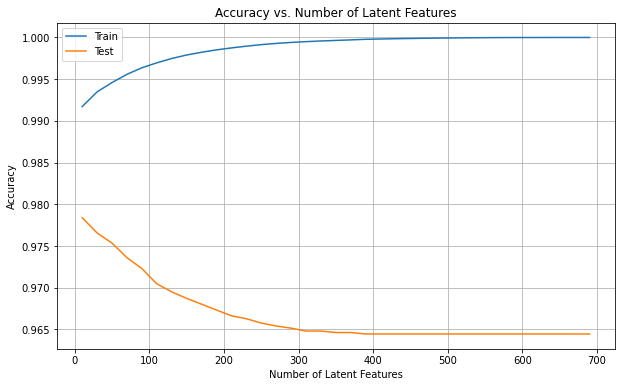

In [117]:
# plot the train and test accuracy vs. the number of latent features
fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(num_latent_feats,
        1 - (np.array(sum_errors_train)/(user_item_train.shape[0]*user_item_train.shape[1])),
        label="Train");
        
plt.plot(num_latent_feats,
         1 - (np.array(sum_errors_test)/(user_intersect_train_test.shape[0]*user_intersect_train_test.shape[1])),
         label="Test");

ax.grid("on")
plt.legend();
plt.xlabel("Number of Latent Features");
plt.ylabel("Accuracy");
plt.title("Accuracy vs. Number of Latent Features");


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

As we can see from the visualization the accuracy of the training set increases as the number of latent features increases, but sadly that's the not the case with our test test. For the test data with increase of latent features the the accuracy only tends to decrease.One plausible cause is overfitting meaning the model pefroms very well on the training data but does not generalize well on test and inference data ( https://stackoverflow.com/questions/37776333/why-too-many-features-cause-over-fitting ). To avoid this scenario we may need to lower the number of latent features. 

Also we have noticed that the matrix used is loaded with sparse features which might also be causing the model not to perform well on the training data (https://www.kdnuggets.com/2021/01/sparse-features-machine-learning-models.html#:~:text=Model%20algorithms%20and%20diagnostic%20measures,This%20is%20called%20overfitting)

We know that we can only make predictions for 20 users in the training data as there is only a small overlap of users between these splits. Maybe an improved accuracy can be observed with the an increase in the overlap of users and not just 20 users or we can use a rank based recoomendation system for the rest of users that we can cannot make recommendations for. Also another method to consider would be to create an A/B test or something similar to it to measure how we can use our new recoomendation system to a section of users and rank based recommendation system to the other group and measure the click rate and time spent on the recommended articles and determine if our new recommendation system is working. When we look at training data accuracy in the visual above there is a steep drop after 50 features and continues to drop till it plateaued out at 400 features from where it remained flat. So around 50 latent features would be an optimal number of latent features in this case. 



References

https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/ <br>
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html <br>
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.unstack.html <br>
https://towardsdatascience.com/introduction-to-pandas-apply-applymap-and-map-5d3e044e93ff <br>
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transpose.html <br>
https://stackoverflow.com/questions/27967914/efficient-way-to-compute-intersecting-values-between-two-numpy- <br>
https://knowledge.udacity.com/questions/770708 <br>
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Index.difference.html <br>
https://pandas.pydata.org/docs/reference/api/pandas.Index.intersection.html <br>
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html <br>
https://stackoverflow.com/questions/27890735/difference-between-listnumpy-array-and-numpy-array-tolist <br>